In [64]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh
import pandas as pd

# IMPORTANDO DADOS

In [65]:
path = 'DataBase.csv'
df   = pd.read_csv(path)
df.head()

,time,pressure
0,0.000,34.1818
1,0.000,34.2099
2,0.096,34.2129
3,0.195,34.1739
4,0.293,34.1464


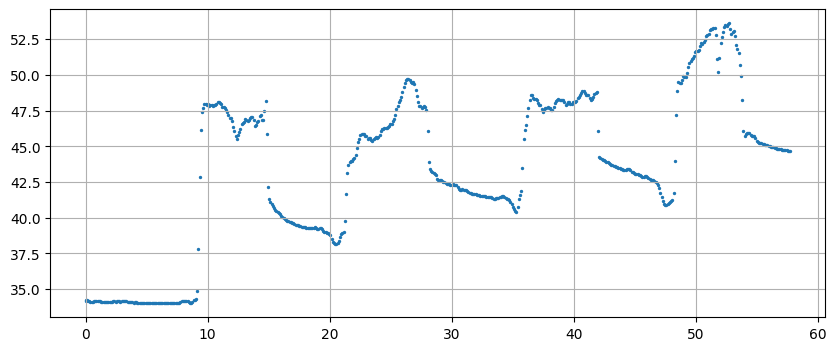

In [66]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, s=2)
plt.grid()

# NORMALIZANDO DADOS

In [67]:
T = 0.100

In [68]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
df

,time,pressure
0,0.0,34.2099
1,0.1,34.2129
2,0.2,34.1739
3,0.3,34.1464
4,0.4,34.1162
...,...,...
574,57.4,44.7218
575,57.5,44.7158
576,57.6,44.6948
577,57.7,44.6635


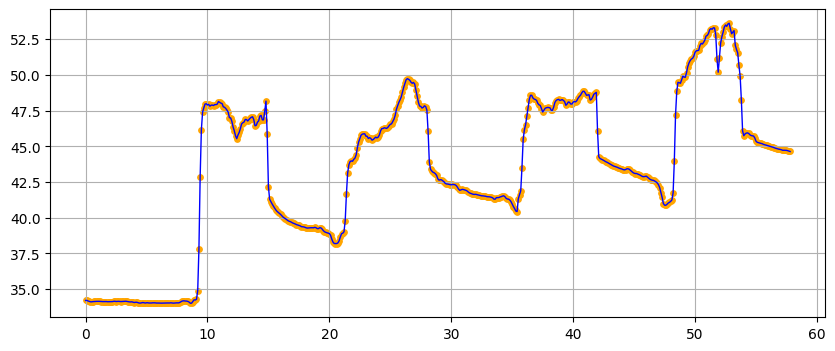

In [69]:
xData, yData = df.time.values, df.pressure.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

# FILTRO PERFEITO
**DOMÍNIO DA FREQUÊNCIA** $\Rightarrow$ Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

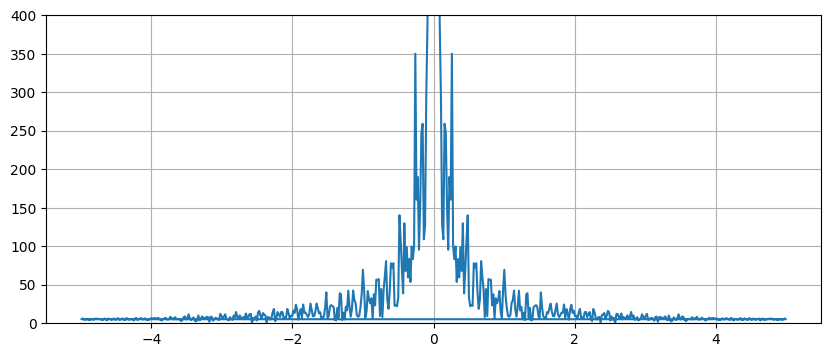

In [70]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), T)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
plt.ylim(0, 400)
plt.grid()

**FILTRO PASSA BAIXA** $\Rightarrow$ O gráfico acima apresenta enorme ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueada

In [71]:
f_c = 0.3

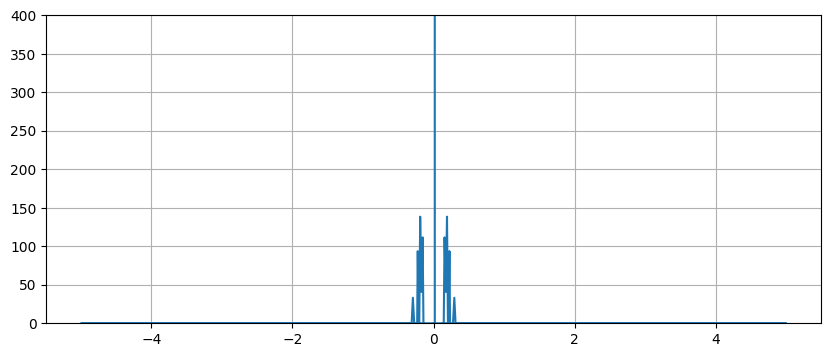

In [72]:
def applyLowBand(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray

magnitude = applyLowBand(frequency, magnitude, f_c)
plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.ylim(0, 400)
plt.grid()

- Voltando para o domínio do tempo

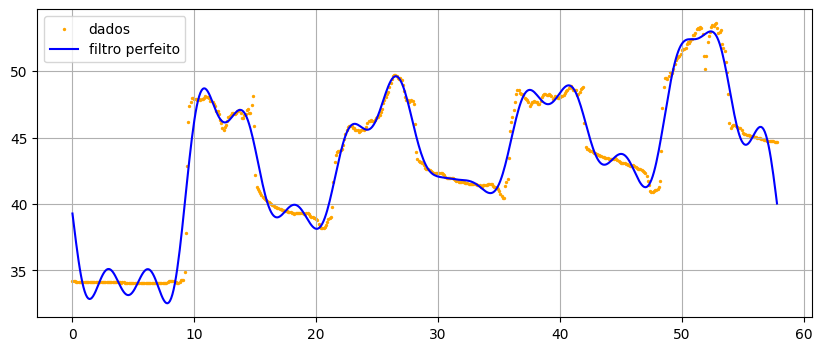

In [73]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, s=2, color='orange', label='dados')
plt.plot(xData, yData, color='blue', label='filtro perfeito')
plt.legend(), plt.grid()
plt.show()

# FILTRO DE FREQUÊNCIA
A função de transferência do filtro de segunda ordem tem cara: 

- $C(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}$ $\,\,\,\,\,\,\,\,\,$ onde $\omega_n$ é a frequência natural (ou frequência de corte) do filtro em rad/s.$
- Sabemos que para atenuação ideal, $|C|_{s \to j\omega_c} = \frac{1}{\sqrt{2}} = 0.707 = \zeta$

In [74]:
s = ctl.TransferFunction.s
zeta = 0.7071067811865475
w_n  = 2*np.pi*f_c

C = w_n**2 / (s**2 + 2*zeta*w_n*s + w_n**2)
C

TransferFunction(array([3.55305758]), array([1.        , 2.66572976, 3.55305758]))

**COMPARAÇÃO COM O FILTRO PADRÃO** $\Rightarrow$ Vamos comparar o filtro perfeito, construído em numpy, com o filtro feito pela função de transferência, os dois devem ser aproximadamente iguais

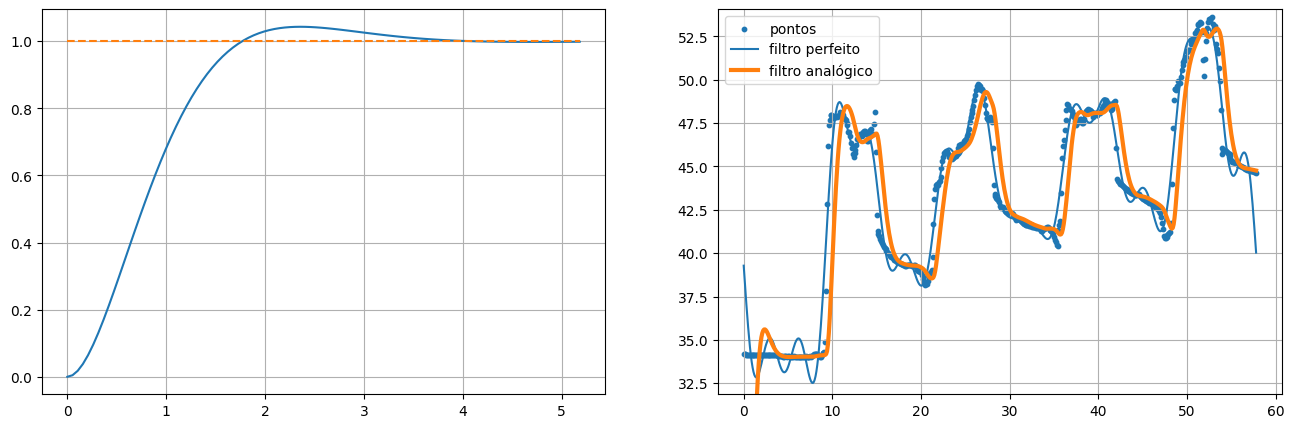

In [75]:
time, response = ctl.step_response(C)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

xTest, yTest  = df.time.values, df.pressure.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.pressure, s=10, label='pontos')
plt.plot(xData, yData, label='filtro perfeito')
plt.plot(time, reponse, label='filtro analógico', linewidth=3)

plt.ylim(min(yData)*0.98, max(yData)*1.02)
plt.legend()
plt.grid()

# FILTRO DIGITAL

In [76]:
C

TransferFunction(array([3.55305758]), array([1.        , 2.66572976, 3.55305758]))

In [77]:
s = ctl.TransferFunction.s
C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([0.01623925, 0.01485765]), array([ 1.        , -1.73490321,  0.7660001 ]), 0.1)

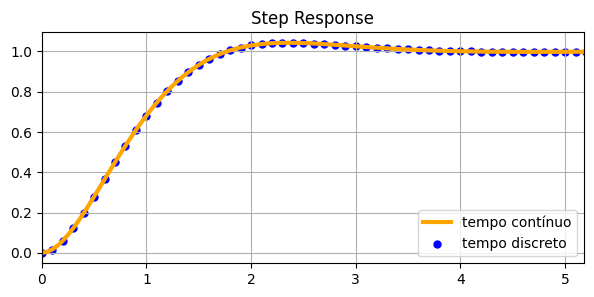

In [78]:
plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)

plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.title('Step Response')
plt.legend()
plt.grid()

- As funções abaixo serão usadas para discretizar a função de transferência no domínio $z$ para uma função a partir dos seus estados anteriores

In [79]:
def getDigitalFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    return list(num), list(den)


num, den = getDigitalFraction(C_z)
num, den

([0.016239246974013577, 0.014857648981437932],
 [1.0, -1.7349032058858211, 0.7660001018412725])

In [80]:
def getModelString(G_z):
    num, den = getDigitalFraction(G_z)
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn[{i}]*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn[{i}]*({-1*den[i]:.6f}) + '
    
    out = out.replace('X_n0', 'X_n')[:-3]
    xSize = len(num)
    ySize = len(den)
    return out, xSize, ySize 


output, xSize, ySize = getModelString(C_z)
print(output + ';')
xSize, ySize

Xn[0]*(0.016239) + Xn[1]*(0.014858) + Yn[1]*(1.734903) + Yn[2]*(-0.766000);


(2, 3)

- Criando a função no "estilo" C++ para confirmar se a máquina consegue implementar

In [81]:
Xn = np.zeros(xSize)
Yn = np.zeros(ySize)

def compute(input):
    global Xn, Yn, xSize, ySize
    
    for n in range(xSize-1, 0, -1):
        Xn[n] = Xn[n-1]

    for n in range(ySize-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Xn[0] = input
    Yn[0] = eval(output)
    return Yn[0]

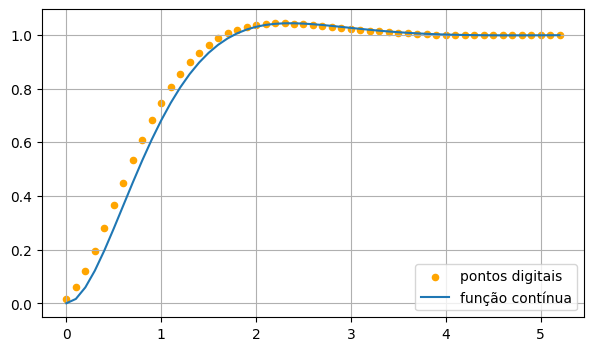

In [82]:
step = 1
digital = [compute(step) for t in time]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

- Comparando o filtro digital com o filtro perfeito

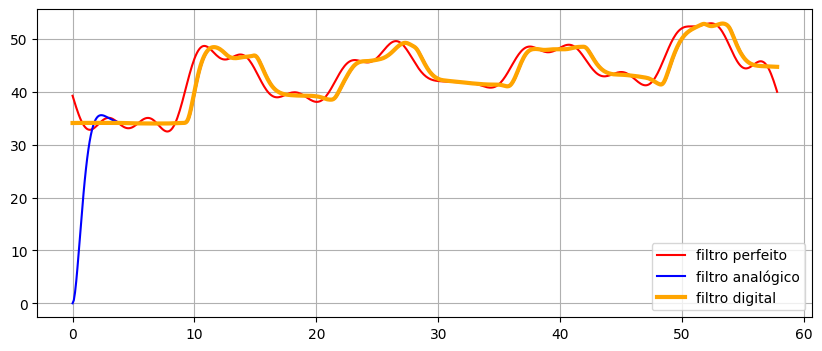

In [83]:
for i in range(1000): compute(df.loc[df.time < 5].pressure.mean())

xTest, yTest  = df.time.values, df.pressure.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)


plt.figure(figsize=(10, 4))
plt.plot(xData, yData, label='filtro perfeito', color='red')
plt.plot(time, reponse, label='filtro analógico', color='blue')
plt.plot(xTest, [compute(y) for y in yTest], label='filtro digital', color='orange', linewidth=3)
plt.legend()
plt.grid()

# COMPARAÇÃO GERAL DOS DADOS

,time,pressure
0,0.0,34.2099
1,0.1,34.2129
2,0.2,34.1739
3,0.3,34.1464
4,0.4,34.1162


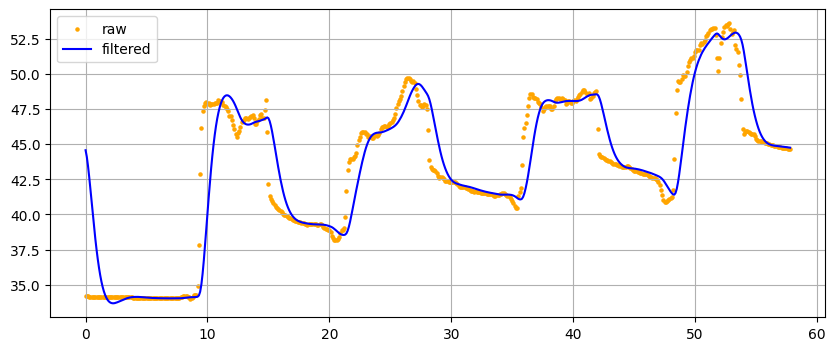

In [84]:
df = pd.read_csv(path) 

df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
display(df.head())

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, color='orange', s=5, label='raw')
plt.plot(df.time, [compute(y) for y in df.pressure], color='blue', label='filtered')

plt.grid()
plt.legend()